# Import libraries

In [1]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys

Using TensorFlow backend.


In [2]:
# Declare variables / parameters

FILEPATH = './HDeviceCGM.csv'
FIXED_WINDOW_SIZE = 10
TRAIN_PCT = 0.7
VAL_PCT = 0.2

# Understanding the data
In this dataset we will be provided with dataset containing the following columns of importance
1. RecID - unique record ID
2. DeviceDtTmDaysFromEroll (Date time index)
3. GlucoseValue (mg/dL) - the output glucose number

Prepare the dataset, filter out the necessary data and split it to its respective test and training sets.

Within each `DeviceDtTmDaysFromEnroll` group, we need to sort the `DeviceTm` in an ascending order. This is because the input data into the LSTM model requires each subarray to be a windowed data, which should be a time series.

In [3]:
df = pd.read_csv(FILEPATH) \
     .sort_values(['DeviceDtTmDaysFromEnroll'], ascending=True) \
     .groupby(['DeviceDtTmDaysFromEnroll'], sort=False) \
     .apply(lambda x: x.sort_values(['DeviceTm'], ascending=True)) \
     .reset_index(drop=True)

df

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,15057726,4110,14,9,0,16:02:32,1,0:02:33,Calibration,53
1,15057725,4110,14,9,0,16:02:55,1,0:02:55,Calibration,57
2,15055588,4110,14,9,0,16:06:58,1,0:06:59,CGM,48
3,15055587,4110,14,9,0,16:11:58,1,0:11:59,CGM,51
4,15055586,4110,14,9,0,16:16:58,1,0:16:59,CGM,52
...,...,...,...,...,...,...,...,...,...,...
2957,15055129,4110,14,9,10,9:36:18,10,17:36:18,CGM,108
2958,15055128,4110,14,9,10,9:41:18,10,17:41:18,CGM,107
2959,15055127,4110,14,9,10,9:46:18,10,17:46:18,CGM,106
2960,15055126,4110,14,9,10,9:51:18,10,17:51:18,CGM,104


### Checkpoint 1: Study the training data-set and answer the following 
1. How many sets of continuous training data sets do you have available
2. The count of sample points per training data sets. Segment the data-sets into training and testing.

In [4]:
# filter out unnecessary data

df = df[['RecID', 'DeviceDtTmDaysFromEnroll', 'GlucoseValue']]
df

,RecID,DeviceDtTmDaysFromEnroll,GlucoseValue
0,15057726,0,53
1,15057725,0,57
2,15055588,0,48
3,15055587,0,51
4,15055586,0,52
...,...,...,...
2957,15055129,10,108
2958,15055128,10,107
2959,15055127,10,106
2960,15055126,10,104


In [5]:
df_grouped = df.groupby(by='DeviceDtTmDaysFromEnroll').agg(count=('RecID', pd.Series.nunique)).reset_index()
NO_OF_INSTANCES = len(df_grouped)

print("There are {} continuous training data sets.".format(NO_OF_INSTANCES))
print("The count of sample points per training dataset is shown below.")

df_grouped

There are 11 continuous training data sets.
The count of sample points per training dataset is shown below.


,DeviceDtTmDaysFromEnroll,count
0,0,101
1,1,292
2,2,290
3,3,291
4,4,294
5,5,297
6,6,290
7,7,231
8,8,292
9,9,291


In [6]:
# create a dataset, which is a list of list
dataset = [[] for i in range(NO_OF_INSTANCES)]

for index, row in df.iterrows():
    group_no = row['DeviceDtTmDaysFromEnroll']
    dataset[group_no].append(row['GlucoseValue'])

print("There are {} datasets.".format(len(dataset))) # a list of 11 instances
print("There are {} records in day 0 dataset.".format(len(dataset[0]))) # each containing a list of glucose values

There are 11 datasets.
There are 101 records in day 0 dataset.


In [7]:
# split into respective training and test sets
train_size = int(len(dataset) * TRAIN_PCT)
val_size = int(len(dataset) * VAL_PCT)
train = dataset[:train_size]
val = dataset[train_size: train_size+val_size]
test =  dataset[train_size+val_size:]

print("There are {} train datasets.".format(len(train)))
print("There are {} val datasets.".format(len(val))) 
print("There are {} test datasets.".format(len(test))) 

There are 7 train datasets.
There are 2 val datasets.
There are 2 test datasets.


# Data Pre-Processing
We would be constructing a Many-to-one LSTM architecture, as such we require the data to be pre-processed into the necessary window size for training.

### Checkpoint 2: Display the dimensions for your pre-processed data and explain how the window size is incorporated into this structure.

In [8]:
# Prepare dataset and labels for our training process
# where we use sequences of i glucose values to generate the (i+1)th glucose value. 
# Keras requires input to be in the shape [samples, time steps, features].
def prepare_Xy(dataset, seq_length):
    X_train = []
    y_train = []
    for i in range(0, len(dataset) - seq_length, 1):
        seq_in = dataset[i:i + seq_length]
        seq_out = dataset[i + seq_length]
        X_train.append(seq_in)
        y_train.append(seq_out)
    seq_size = len(X_train)
    X_train = np.reshape(X_train, (seq_size, seq_length, 1))
    y_train = np.array(y_train)
        
    return X_train, y_train

In [9]:
# Dict format: {day: X, y}

train_dict = {idx: prepare_Xy(train[idx], FIXED_WINDOW_SIZE) for idx in range(len(train))}
val_dict = {idx+len(train): prepare_Xy(val[idx], FIXED_WINDOW_SIZE) for idx in range(len(val))}
test_dict = {idx+len(train)+len(val): prepare_Xy(test[idx], FIXED_WINDOW_SIZE) for idx in range(len(test))}

In [10]:
train_dict, val_dict, test_dict

({0: (array([[[ 53],
           [ 57],
           [ 48],
           [ 51],
           [ 52],
           [ 45],
           [ 47],
           [ 52],
           [ 54],
           [ 55]],
   
          [[ 57],
           [ 48],
           [ 51],
           [ 52],
           [ 45],
           [ 47],
           [ 52],
           [ 54],
           [ 55],
           [ 51]],
   
          [[ 48],
           [ 51],
           [ 52],
           [ 45],
           [ 47],
           [ 52],
           [ 54],
           [ 55],
           [ 51],
           [ 50]],
   
          [[ 51],
           [ 52],
           [ 45],
           [ 47],
           [ 52],
           [ 54],
           [ 55],
           [ 51],
           [ 50],
           [ 56]],
   
          [[ 52],
           [ 45],
           [ 47],
           [ 52],
           [ 54],
           [ 55],
           [ 51],
           [ 50],
           [ 56],
           [ 64]],
   
          [[ 45],
           [ 47],
           [ 52],
           [ 54],


Keras requires input to be in the shape [samples, time steps, features]. Because we set the window size to be 10, we have the following data structure as input into the model: $X = [[[x_{1}], ..., [x_{10}]], [[x_{2}], ..., [x_{11}]], ..., [[x_{n-11}], ..., [x_{n-1}]]]$, with the corresponding $y = [y_{1}, y_{2}, ..., y_{n}]$. It is important to realize that each day is a different continuous dataset, so we cannot assume that the true label of the last sequence for day 0 is the first value from day 1. The data needs to processed carefully.

In this question, the window size refers to the number of time steps. Generally, if we have a window size of 10 and GlucoseValue as the only feature, we have a single labeled sample in the following form: $X[i] = [[x_{i}], [x_{i+1}], ... ,[x_{i+9}], [x_{i+10}]]$, and $y[i] = x_{i+11}$.

Extra note to self: If there are multiple features such as HeartRate, we could keep the same window size and easily add modify the data structure as such: $X[i] = [[x_{i}, u_{i}], [x_{i+1}, u_{i+1}], ... ,[x_{i+9}, u_{i+9}], [x_{i+10}, u_{i+10}]]$, and $y[i] = x_{i+11}$.

Once the labeled data $(X_{i}, y_{i})$ for each day i has been generated, there can then be 2 approaches:
1. All the $(X_{i}, y_{i})$ can be concatenated into a single (X_train, y_train) for training. The validation and test dataset can be processed in a similar way. 
2. Train or evaluate the model for each day in an iterative manner.

For training and validation, I chose the first approach. For testing, I chose the second approach because I want to keep track of the evaluation results for each day.

In [11]:
def concat_Xy(ds_dict):
    """
    Takes in a dictionary of the following form: {day 0: (X0,y0), ..., day n: (Xn, yn)}
    Returns 3D X and y arrays
    """
    X_concat = []
    y_concat = []
    for k, (X, y) in ds_dict.items():
        for xi, yi in zip(X,y):
            X_concat.append(xi)
            y_concat.append(yi)
    return np.array(X_concat), np.array(y_concat)

In [12]:
# Prepare training and validation data to be fed into the model
X_train, y_train = concat_Xy(train_dict)
X_val, y_val = concat_Xy(val_dict)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1785, 10, 1), (1785,), (503, 10, 1), (503,))

### Checkpoint 3: Explain how this many-to-one structure presented is incorporated in your data structure.

Following the above description, we require 10 timesteps to make a single prediction during training phase. We only care about the final output state at the final timestamp. Every other hidden output state in between is ignored.

<img src="many-to-one-archi.JPG" width="500" align="center" />

# Modelling and Training

### Checkpoint 4: Select the correct Loss Function and optimiser and explain the reason for your choice.

I use mean squared error because my output is an unbounded continuous value. Using this error function penalizes greater difference between the predicted and actual output more severely. This will help to reduce deviation. However, I also keep track of mean absolute error, which indicates the absolute difference between the predicted and actual output. This is a metric that is easier for users to comprehend.

I use Adam due to its ability to leverage the power of adaptive learning rates methods to find individual learning rates for each parameter. Specifically, it uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum. As the algorithm combines the advantages of several other optimizers, choosing Adam therefore sounds like a reasonable approach to begin with.

In [13]:
# Construct our LSTM model

def build_model(window_size):
    model = Sequential()
    model.add(LSTM(256, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=30, batch_size=4, callbacks=[]):
    model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=callbacks)
    train_losses = model_history.history['loss']
    val_losses = model_history.history['val_loss']
    return train_losses, val_losses

In [14]:
# Define callbacks

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)

In [15]:
# Train our LSTM model

model = build_model(FIXED_WINDOW_SIZE)
train_losses, val_losses = train_model(model, X_train, y_train, X_val, y_val, callbacks=[es, mc])

Train on 1785 samples, validate on 503 samples
Epoch 1/30
1785/1785 [==============================] - 7s 4ms/step - loss: 10050.4413 - mae: 77.5232 - val_loss: 3335.0068 - val_mae: 45.0967
Epoch 2/30
1785/1785 [==============================] - 6s 3ms/step - loss: 3092.5829 - mae: 31.4024 - val_loss: 999.7447 - val_mae: 18.9882
Epoch 3/30
1785/1785 [==============================] - 6s 3ms/step - loss: 1556.9535 - mae: 18.3814 - val_loss: 425.3785 - val_mae: 9.9430
Epoch 4/30
1785/1785 [==============================] - 6s 3ms/step - loss: 955.7339 - mae: 12.3051 - val_loss: 262.9691 - val_mae: 7.0857
Epoch 5/30
1785/1785 [==============================] - 6s 3ms/step - loss: 684.6343 - mae: 9.6569 - val_loss: 217.9044 - val_mae: 8.1538
Epoch 6/30
1785/1785 [==============================] - 6s 3ms/step - loss: 515.8103 - mae: 8.2215 - val_loss: 157.0471 - val_mae: 5.1318
Epoch 7/30
1785/1785 [==============================] - 6s 3ms/step - loss: 409.7528 - mae: 7.5438 - val_loss: 146

In [16]:
# Load best weights
model.load_weights('best_weights.h5')

In [17]:
# sanity check
test_input = np.array([[[53],[57],[48],[51],[52],[45],[47],[52],[54],[55]]])
model.predict(test_input)

array([[63.95112]], dtype=float32)

### Checkpoint 5: Graph and display the training loss of the model.

In [18]:
def performance_graph(train_loss_hist, val_loss_hist):
    plt.plot(train_loss_hist, 'g', label='Training')
    plt.plot(val_loss_hist, 'b', label='Validation')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

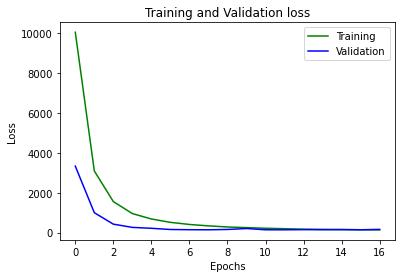

In [19]:
performance_graph(train_losses, val_losses)

# Validation
Now that we have our trained model, we would want to validate it on the rest of the remaining data to ensure that our model is not only accurate on a single session data but for mutiple other instance. Utilise the model on the remaining data available and show that the model accuracy is acceptable.

### Checkpoint 6: Graph the remaining instances and plot them
Provide the true data and the validated data on the same graph, display the mean loss for each of the instance.

In [20]:
def test_model(model, X_test, y_test):
    _, test_mae = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    return y_pred, test_mae

def evaluation_graph(y_true, y_pred):    
    plt.plot(y_true, 'g', label='True')
    plt.plot(y_pred, 'b', label='Predicted')
    plt.title('Glucose Value vs timestep')
    plt.xlabel('Timestep')
    plt.ylabel('Glucose Value')
    plt.legend()
    plt.show()

=============== TESTING ON DAY 9 ===============
281/281 [==============================] - 0s 79us/step
The test mean absolute loss is 2.6964271068573


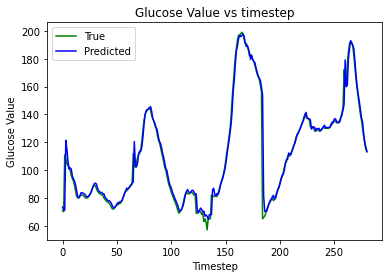

=============== TESTING ON DAY 10 ===============
283/283 [==============================] - 0s 76us/step
The test mean absolute loss is 8.483451843261719


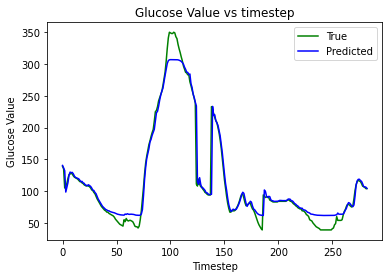

In [21]:
for k, (X,y) in test_dict.items():
    print("=============== TESTING ON DAY {} ===============".format(k))
    y_pred, test_mae = test_model(model, X, y)
    print("The test mean absolute loss is {}".format(test_mae))
    evaluation_graph(y, y_pred)

From the results, the predicted curve follows the true curve very closely. This means that the LSTM model is able to predict the trend very well.

However, for day 10, it appears that the model is not able to predict very well for periods with very high or very low glucose values. This is likely due to fewer train data that contain such extreme values. Hence, for periods with more extreme values, it would make more sense for the model to predict a value that is closer to the mean in order to reduce the loss.

# Optimisation
We would now want to optimise the prediction accuracy by carrying out hyperparameter optimisation. Vary the windows size of the model and find the optimal window size that gives back the lowest loss.

### Checkpoint 7: Write a short report presenting your analysis on the optimal hyper-parameter of choice. You may include the necessary graphs or printout to explain your optimal hyper-parameter of choice.

Hyperparameter tuning should only be based on validation data, and not the train or test data. The most optimal hyperparameter is the one that produces the lowest validation loss.

In [22]:
window_sizes = [5, 10, 15, 20, 25, 30]

best_size = None
lowest_loss = float('inf')
window_perf_dict = dict()

for size in window_sizes:
    print("=============== WINDOW SIZE {} ===============".format(size))
    
    # Prepare data
    train_dict = {idx: prepare_Xy(train[idx], size) for idx in range(len(train))}
    val_dict = {idx+len(train): prepare_Xy(val[idx], size) for idx in range(len(val))}
    X_train, y_train = concat_Xy(train_dict)
    X_val, y_val = concat_Xy(val_dict)
    
    # Train model
    model = build_model(size)
    _, val_losses = train_model(model, X_train, y_train, X_val, y_val, callbacks=[es])
    model_loss = min(val_losses) # since we save the model weights by their lowest validation loss
    window_perf_dict[size] = model_loss
    
    if model_loss < lowest_loss:
        lowest_loss = model_loss
        best_size = size

=============== WINDOW SIZE 5 ===============
Train on 1820 samples, validate on 513 samples
Epoch 1/30
1820/1820 [==============================] - 4s 2ms/step - loss: 9715.5726 - mae: 75.6540 - val_loss: 2930.0680 - val_mae: 38.4815
Epoch 2/30
1820/1820 [==============================] - 4s 2ms/step - loss: 2862.7251 - mae: 29.4122 - val_loss: 855.6915 - val_mae: 16.4953
Epoch 3/30
1820/1820 [==============================] - 4s 2ms/step - loss: 1428.3572 - mae: 17.0751 - val_loss: 411.8640 - val_mae: 9.7795
Epoch 4/30
1820/1820 [==============================] - 4s 2ms/step - loss: 916.1491 - mae: 12.5687 - val_loss: 272.6118 - val_mae: 8.1563
Epoch 5/30
1820/1820 [==============================] - 4s 2ms/step - loss: 711.0632 - mae: 10.4740 - val_loss: 212.1080 - val_mae: 7.0418
Epoch 6/30
1820/1820 [==============================] - 4s 2ms/step - loss: 526.0287 - mae: 8.3856 - val_loss: 173.3880 - val_mae: 6.3427
Epoch 7/30
1820/1820 [==============================] - 4s 2ms/step 

In [23]:
def hyperparmeter_graph(data):
    plt.bar(range(len(data)), list(data.values()), align='center')
    plt.xticks(range(len(data)), list(data.keys()))
    plt.title("Validation loss vs window sizes")
    plt.xlabel('Window sizes')
    plt.ylabel('Validation loss')
    plt.show()

The most optimal window size is 20


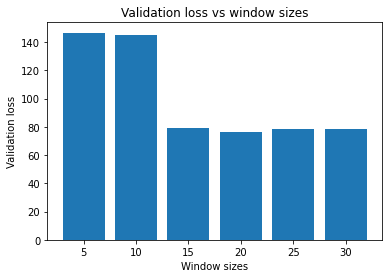

In [24]:
print("The most optimal window size is {}".format(best_size))
hyperparmeter_graph(window_perf_dict)

The validation MSE loss is higher when window sizes are smaller (i.e. 5 or 10). The validation loss becomes much lower when window sizes are larger (i.e. 15, 20, 25, 30), although it remains about the same. This is expected because a larger window size means that the model can take advantage of more data from previous timesteps before making a prediction.